# Large-scale MMD-MA

In this tutorial, we show how to use the package `lsmmdma` that implements a large scale version of [MMD-MA](https://pubmed.ncbi.nlm.nih.gov/34632462/). MMD-MA's objective is to match points from two separate cloud points in a low-dimensional space.

In [1]:
!pip install lsmmdma

In [ ]:
import lsmmdma
from lsmmdma import train
from lsmmdma.data import data_pipeline
from lsmmdma import metrics
import numpy as np
import torch

from IPython import display
from IPython.display import Image
from matplotlib import animation
from matplotlib import cm
import matplotlib.pyplot as plt

## Example on a simulated dataset

First we download a simulation dataset that corresponds to the second simulation used in the [MMD-MA](https://pubmed.ncbi.nlm.nih.gov/34632462/) paper.

In [ ]:
# Downloads data.
!wget https://bitbucket.org/noblelab/2019_mmd_wabi/raw/8921b4e75eee6be431a7063efe2bfeee47ba165a/X2_linearkernel.tsv
!wget https://bitbucket.org/noblelab/2019_mmd_wabi/raw/8921b4e75eee6be431a7063efe2bfeee47ba165a/Y2_linearkernel.tsv

In [4]:
# Loads data on device.
if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = 'cpu'

path = ''
kernel1 = data_pipeline.load(path, 'X2_linearkernel.tsv')
kernel2 = data_pipeline.load(path, 'Y2_linearkernel.tsv')
kernel1 = torch.FloatTensor(kernel1).to(device)
kernel2 = torch.FloatTensor(kernel2).to(device)

In order to use the algorithm from `lsmmdma`, we first need to instantiate a config module. It contains several hyperparameters (see [main.py](https://github.com/google-research/large_scale_mmdma/blob/master/lsmmdma/main.py)) and defines the type of algorithm used:
- `mode`: can be `primal` or `dual`
- `keops`: can be `True` or `False` (see [KeOps](https://www.kernel-operations.io/keops/python/installation.html) for more information).

More details about how to choose the `mode` and whether to set `keops` to `True` are given at the bottom of the Colab.

In this example, we choose to use the dual mode without keops, as the number of samples is small. The dimension of the latent space is chosen to be 5. 

In [5]:
# Defines the algorithm and input.
cfg_model = train.ModelGetterConfig(key=327427, n_iter=10001, mode='dual', 
                                    low_dim=5, n_eval=100, keops=False, pca=100, 
                                    learning_rate=5e-5, sigmas=0.1, 
                                    n_record=100, lambda1=1e-9, lambda2=1e-7, 
                                    init='uniform,0.,0.1')

n = kernel1.shape[0]
# Identifies the ground truth match between the points in the two point clouds.
# rd_vec corresponds to the ground truth ordering of the indices of the first view.
rd_vec = np.arange(n) 
# Instantiates the metrics. 
eval_fn = metrics.SupervisedEvaluation(rd_vec, device)  
# Trains the model.
out = train.train_and_evaluate(cfg_model, kernel1, kernel2, eval_fn, '', device)  
_, _, eval_loss, eval_matching, pca_results, key = out

Done.
[pyKeOps] Compiling libKeOpstorch73b46ee8b0 in /root/.cache/pykeops-1.5-cpython-37:
       formula: ArgKMin_Reduction(Sum(Square((Var(0,5,0) - Var(1,5,1)))),15,0)
       aliases: Var(0,5,0); Var(1,5,1); 
       dtype  : float32
... 
Done.


The loss and various metrics (Top1, Top5 and FOSCTTM (fraction of samples closer than the true match, the lower the better)) can be visualised using the output of the training function.

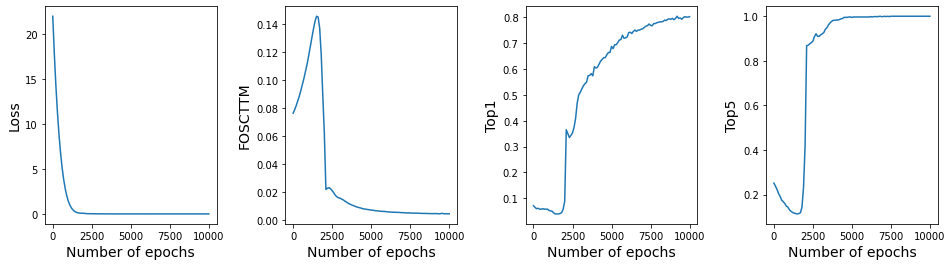

In [6]:
# Evolution of the loss and various metrics.
ft = 14
yaxis = ['Loss', 'FOSCTTM', 'Top1', 'Top5']
content = [eval_loss['loss'], eval_matching['foscttm'], 
           eval_matching['top1'], eval_matching['top5']]
epochs = np.arange(0, 10001, 100)
fig, ax = plt.subplots(1, 4, figsize=(16, 4))
for i in range(4):
  ax[i].plot(epochs, content[i])
  ax[i].set_xlabel('Number of epochs', fontsize=ft)
  ax[i].set_ylabel(yaxis[i], fontsize=ft)
plt.subplots_adjust(wspace=0.4)
plt.show()

For a better visualisation of the matching, PCA is applied to the resulting embeddings to project the results in 2D.

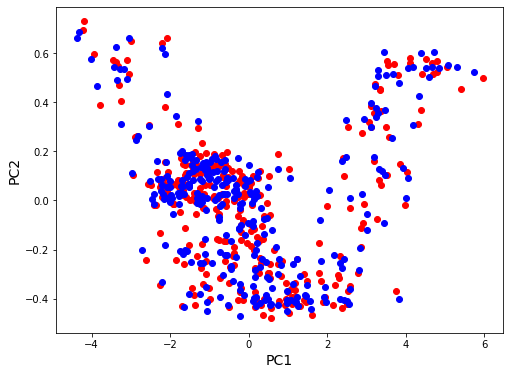

In [7]:
# Plots 2D representation
fig = plt.figure(figsize=(8, 6))
sc_1 = plt.scatter(pca_results[-1][0][:, 0], pca_results[-1][0][:, 1], color='r')
sc_2 = plt.scatter(pca_results[-1][1][:, 0], pca_results[-1][1][:, 1], color='b')
plt.xlabel('PC1', fontsize=14)
plt.ylabel('PC2', fontsize=14)  
plt.show()

The evolution of the matching can also be studied in 2D.

In [8]:
epochs = np.arange(5, 101, 5)

# Animates the 2D representation
fig, ax = plt.subplots(figsize=(8, 6))
sc_1, = plt.plot([], [], color='r', ls='', marker='o')
sc_2, = plt.plot([], [], color='b', ls='', marker='o')
plt.xlabel('PC1', fontsize=14)  # IDs are ordered from center to outer part
plt.ylabel('PC2', fontsize=14)  # IDs are ordered from center to outer part

size = pca_results[1][0].shape
# Initialization function
def init():
    ax.set_xlim(-25, 25)
    ax.set_ylim(-25, 25)
    return [sc_1, sc_2]

# Animation function
def animate(i):
    sc_1.set_data(pca_results[i][0][:, 0], pca_results[i][0][:, 1])
    sc_2.set_data(pca_results[i][1][:, 0], pca_results[i][1][:, 1])
    low_x = np.minimum(pca_results[i][0][:, 0].min(), pca_results[i][1][:, 0].min())
    high_x = np.maximum(pca_results[i][0][:, 0].max(), pca_results[i][1][:, 0].max())
    low_y = np.minimum(pca_results[i][0][:, 1].min(), pca_results[i][1][:, 1].min())
    high_y = np.maximum(pca_results[i][0][:, 1].max(), pca_results[i][1][:, 1].max())
    ax.set_xlim(low_x, high_x)
    ax.set_ylim(low_y, high_y)
    ax.set_title(f'Epoch {i * 100}')
    return [sc_1, sc_2]


# Call the animator
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=epochs,
                               interval=1000, blit=True)

html = display.HTML(anim.to_jshtml())
display.display(html)
plt.close()

## How to choose between `dual` and `primal` / with or without `keops`

These plots compare how much time 500 epochs take as a function of the number of samples and features of the input data (we assume here that both views have the same number of features and samples), for the primal and dual formulations, with and without KeOps. Dark blue regions and dark purple regions indicate regions where the denominator method (in the log ratio) were OOM.


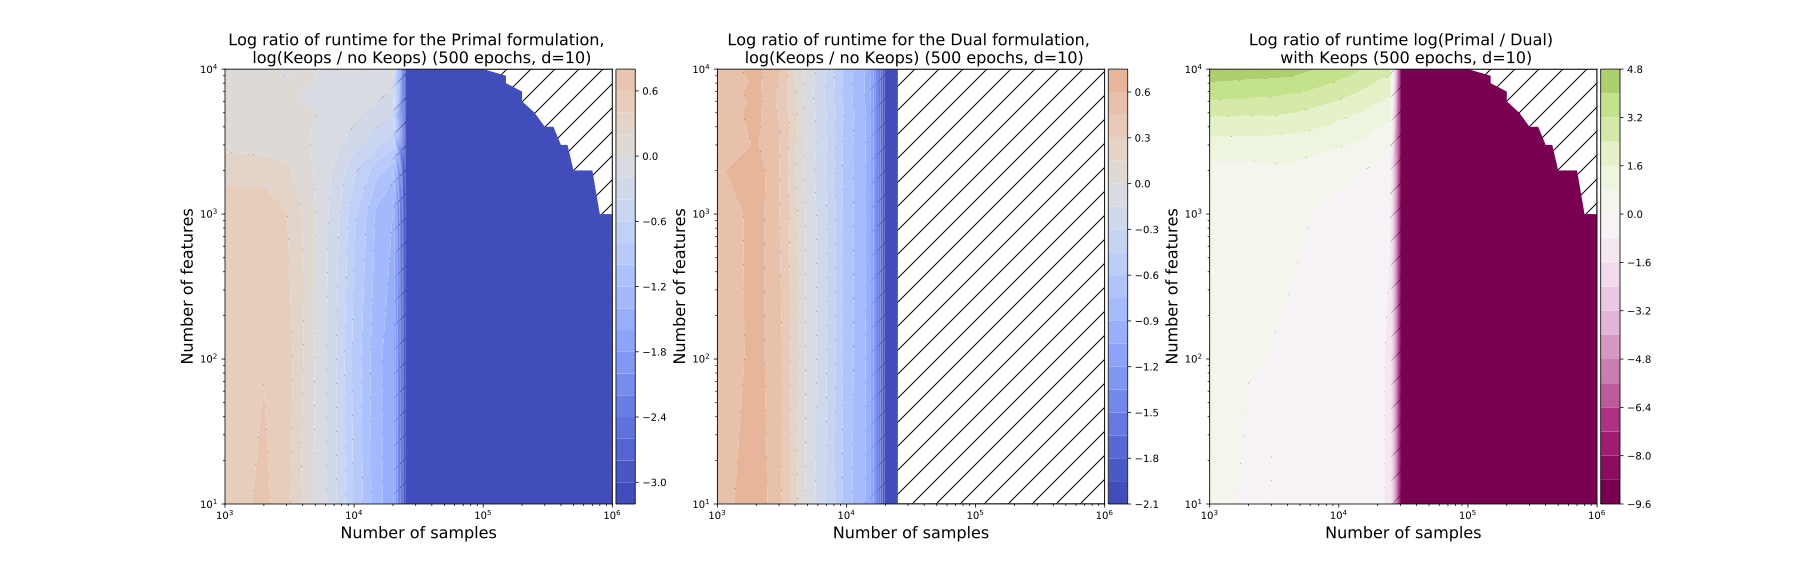

In [9]:
Image('contourplot.png')